In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

2024-04-16 18:53:12.091796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 18:53:13.095640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_2000_balanced.csv')

In [ ]:
dataset.shape

(1825, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1751    set flame grand truth vouchsafed feel importan...
1362    jules gave cautious glance shoulder towards ho...
93      truly calabrian horses snorted pranced manes b...
45      oh says 'll miss said patty 's like alone 's s...
183     'this friend durandarte flower mirror true lov...
1163    space somewhat impressive tableau humorous wel...
1788    sunday th december  way climbed eastern shin h...
498     came however reverse fine day spring mountain ...
1567    morning buoys set lake end measured course cou...
121     holding breath waited motion stable began clim...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 128
vocab_size = 10000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(filters=512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 6000, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5997, 512)      │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2998, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,685,292 (6.43 MB)

 Trainable params: 1,685,292 (6.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 890ms/step - accuracy: 0.0291 - loss: 3.7453 - val_accuracy: 0.0342 - val_loss: 3.6330
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 881ms/step - accuracy: 0.0735 - loss: 3.5128 - val_accuracy: 0.0822 - val_loss: 3.4553
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 876ms/step - accuracy: 0.0913 - loss: 3.3303 - val_accuracy: 0.1507 - val_loss: 3.0958
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 880ms/step - accuracy: 0.1747 - loss: 2.9307 - val_accuracy: 0.2329 - val_loss: 2.7173
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step - accuracy: 0.2574 - loss: 2.6229 - val_accuracy: 0.2740 - val_loss: 2.4247
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 609ms/step - accuracy: 0.3238 - loss: 2.2443 - val_accuracy: 0.3356 - val_loss: 2.1018
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 882ms/step - accuracy: 0.4243 - loss: 1.8961 - val_accuracy: 0.4452 - val_loss: 1.9463
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 879ms/step - accuracy: 0.4599 - loss: 1.7434 - val_accu

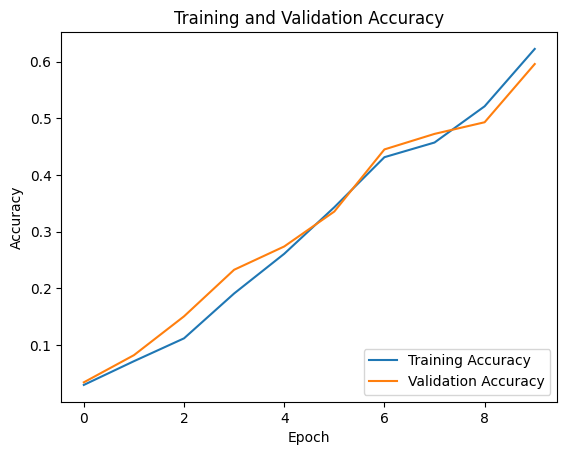

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5995 - loss: 1.4560
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6136986301369863
F1 Score: 0.585067697851231
Precision: 0.6256622829931706
Recall: 0.6136986301369863


## Model 1 - vacsi vobac_size


In [ ]:
embedding_dim = 128
vocab_size = 20000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(filters=512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 6000, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5997, 512)      │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2998, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,965,292 (11.31 MB)

 Trainable params: 2,965,292 (11.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 816ms/step - accuracy: 0.0330 - loss: 3.7277 - val_accuracy: 0.0274 - val_loss: 3.6070
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 884ms/step - accuracy: 0.0726 - loss: 3.5040 - val_accuracy: 0.1164 - val_loss: 3.3402
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 882ms/step - accuracy: 0.1304 - loss: 3.1618 - val_accuracy: 0.2534 - val_loss: 2.9328
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 880ms/step - accuracy: 0.2004 - loss: 2.8352 - val_accuracy: 0.2397 - val_loss: 2.6377
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 879ms/step - accuracy: 0.2671 - loss: 2.4828 - val_accuracy: 0.3904 - val_loss: 2.2490
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 881ms/step - accuracy: 0.3925 - loss: 1.9988 - val_accuracy: 0.3288 - val_loss: 2.6229
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 878ms/step - accuracy: 0.4567 - loss: 1.7937 - val_accuracy: 0.4589 - val_loss: 1.7926
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 881ms/step - accuracy: 0.5750 - loss: 1.4172 - val_accu

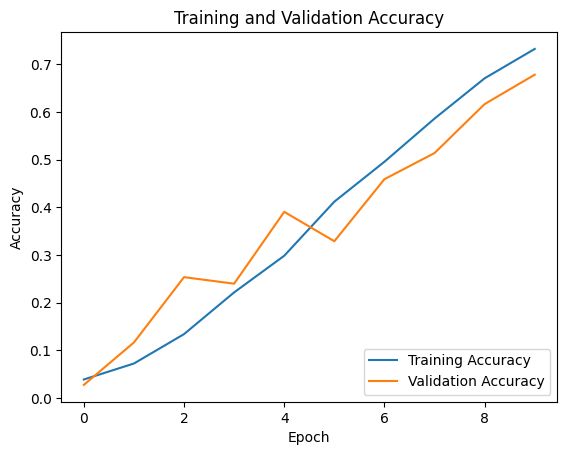

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.7020 - loss: 1.2276
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7068493150684931
F1 Score: 0.7014173396668276
Precision: 0.7778380371531057
Recall: 0.7068493150684931


## Model 1 - este vacsi vocab_size

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_7            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 6000, 256)      │    15,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5997, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2998, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027,436 (61.14 MB)

 Trainable params: 16,027,436 (61.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 924ms/step - accuracy: 0.0361 - loss: 3.7236 - val_accuracy: 0.0342 - val_loss: 3.5647
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 916ms/step - accuracy: 0.0825 - loss: 3.4740 - val_accuracy: 0.1438 - val_loss: 3.2219
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 913ms/step - accuracy: 0.1608 - loss: 3.0521 - val_accuracy: 0.2740 - val_loss: 2.6923
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 915ms/step - accuracy: 0.2893 - loss: 2.4675 - val_accuracy: 0.3630 - val_loss: 2.1242
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 912ms/step - accuracy: 0.4348 - loss: 1.8658 - val_accuracy: 0.4658 - val_loss: 1.7535
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 913ms/step - accuracy: 0.5745 - loss: 1.4331 - val_accuracy: 0.5890 - val_loss: 1.4698
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 909ms/step - accuracy: 0.7043 - loss: 1.0274 - val_accuracy: 0.6370 - val_loss: 1.2586
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 911ms/step - accuracy: 0.8256 - loss: 0.6865 - val_accu

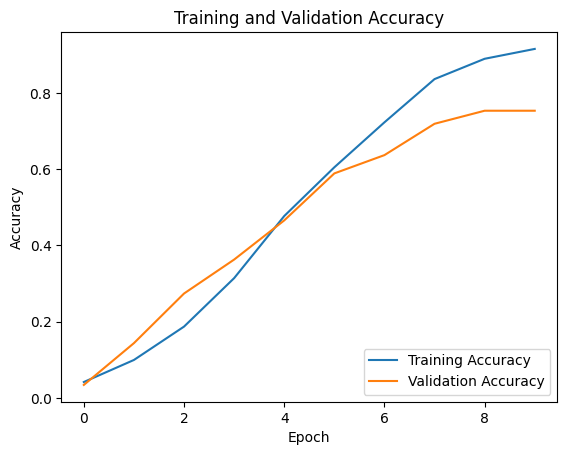

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.7688 - loss: 0.8997
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7698630136986301
F1 Score: 0.7714613533769545
Precision: 0.8110506578657265
Recall: 0.7698630136986301


## Model 2

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(256, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_8            │ (None, 6000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 6000, 256)      │    15,360,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 5997, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2998, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2995, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1497, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 44)             │         5,676 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,268 (63.37 MB)

 Trainable params: 16,612,268 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - accuracy: 0.0286 - loss: 3.7610 - val_accuracy: 0.0274 - val_loss: 3.5465
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.0549 - loss: 3.4385 - val_accuracy: 0.0890 - val_loss: 3.2276
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 339ms/step - accuracy: 0.1096 - loss: 3.1034 - val_accuracy: 0.1986 - val_loss: 2.8952
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.1793 - loss: 2.6785 - val_accuracy: 0.2260 - val_loss: 2.4870
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.3034 - loss: 2.1568 - val_accuracy: 0.2808 - val_loss: 2.3256
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 339ms/step - accuracy: 0.3752 - loss: 1.8294 - val_accuracy: 0.3904 - val_loss: 2.0863
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.4428 - loss: 1.5664 - val_accuracy: 0.3356 - val_loss: 2.1815
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.4965 - loss: 1

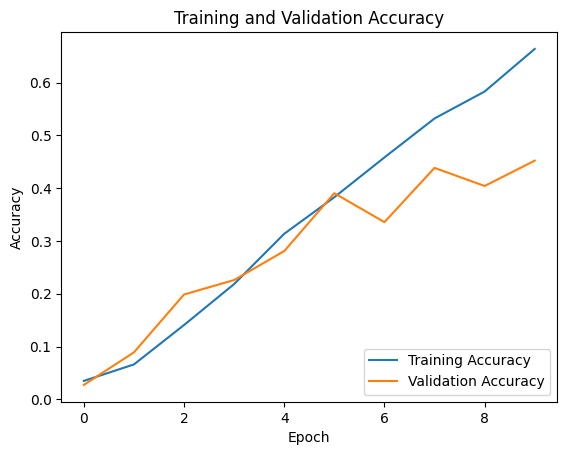

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.3957 - loss: 2.3976
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.4136986301369863
F1 Score: 0.409660597492008
Precision: 0.48605456667821484
Recall: 0.4136986301369863
